In [1]:
pip install kaggle


Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
print(os.getcwd())


C:\Users\Garima Joshi


In [9]:
shutil.move(r"C:\Users\Garima Joshi\Downloads\kaggle.json", os.path.join(kaggle_dir, "kaggle.json"))


'C:\\Users\\Garima Joshi/.kaggle\\kaggle.json'

In [11]:
os.environ['KAGGLE_CONFIG_DIR'] = kaggle_dir


In [13]:
!kaggle competitions list


ref                                                                              deadline             category                reward  teamCount  userHasEntered  
-------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2025                               2025-11-03 23:59:00  Featured         1,000,000 Usd        864           False  
https://www.kaggle.com/competitions/openai-gpt-oss-20b-red-teaming               2025-08-26 23:59:00  Featured           500,000 Usd          0           False  
https://www.kaggle.com/competitions/make-data-count-finding-data-references      2025-09-09 23:59:00  Research           100,000 Usd       1098           False  
https://www.kaggle.com/competitions/jigsaw-agile-community-rules                 2025-10-24 06:59:00  Featured           100,000 Usd        936           False  
https://www.kaggle.com/compe

In [15]:
!kaggle competitions download -c bosch-production-line-performance -p ./bosch_data


403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/competitions/data/download-all/bosch-production-line-performance


In [ ]:
!kaggle competitions download -c bosch-production-line-performance -p ./bosch_data


In [18]:
import os
print(os.listdir("./bosch_data"))


['bosch-production-line-performance.zip']


In [20]:
import zipfile

with zipfile.ZipFile("./bosch_data/bosch-production-line-performance.zip", 'r') as zip_ref:
    zip_ref.extractall("./bosch_data")


In [23]:
print(os.listdir("./bosch_data"))


['bosch-production-line-performance.zip', 'sample_submission.csv.zip', 'test_categorical.csv.zip', 'test_date.csv.zip', 'test_numeric.csv.zip', 'train_categorical.csv.zip', 'train_date.csv.zip', 'train_numeric.csv.zip']


In [25]:
import pandas as pd

df = pd.read_csv("./bosch_data/train_numeric.csv.zip", nrows=50000)

print(df.shape)
print(df.head())


(50000, 970)
   Id  L0_S0_F0  L0_S0_F2  L0_S0_F4  L0_S0_F6  L0_S0_F8  L0_S0_F10  L0_S0_F12  \
0   4     0.030    -0.034    -0.197    -0.179     0.118      0.116     -0.015   
1   6       NaN       NaN       NaN       NaN       NaN        NaN        NaN   
2   7     0.088     0.086     0.003    -0.052     0.161      0.025     -0.015   
3   9    -0.036    -0.064     0.294     0.330     0.074      0.161      0.022   
4  11    -0.055    -0.086     0.294     0.330     0.118      0.025      0.030   

   L0_S0_F14  L0_S0_F16  ...  L3_S50_F4245  L3_S50_F4247  L3_S50_F4249  \
0     -0.032      0.020  ...           NaN           NaN           NaN   
1        NaN        NaN  ...           NaN           NaN           NaN   
2     -0.072     -0.225  ...           NaN           NaN           NaN   
3      0.128     -0.026  ...           NaN           NaN           NaN   
4      0.168     -0.169  ...           NaN           NaN           NaN   

   L3_S50_F4251  L3_S50_F4253  L3_S51_F4256  L3_S51_F42

In [27]:
import pandas as pd

# Ensure 'Response' column exists
if 'Response' in df.columns:
    start_date = pd.to_datetime("2021-01-01 00:00:00")
    df['synthetic_timestamp'] = [start_date + pd.Timedelta(seconds=i) for i in range(len(df))]
    print(df[['Response', 'synthetic_timestamp']].head())
else:
    print("Response column not found in this subset!")


   Response synthetic_timestamp
0         0 2021-01-01 00:00:00
1         0 2021-01-01 00:00:01
2         0 2021-01-01 00:00:02
3         0 2021-01-01 00:00:03
4         0 2021-01-01 00:00:04


In [33]:
# Sort by timestamp just in case
df = df.sort_values("synthetic_timestamp").reset_index(drop=True)

# Compute split indices
n = len(df)
train_end = int(0.6 * n)
test_end  = int(0.8 * n)

# Create splits
train_data = df.iloc[:train_end]
test_data  = df.iloc[train_end:test_end]
sim_data   = df.iloc[test_end:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Simulation shape:", sim_data.shape)

# Quick check
print(train_data['synthetic_timestamp'].min(), "->", train_data['synthetic_timestamp'].max())
print(test_data['synthetic_timestamp'].min(), "->", test_data['synthetic_timestamp'].max())
print(sim_data['synthetic_timestamp'].min(), "->", sim_data['synthetic_timestamp'].max())


Train shape: (30000, 971)
Test shape: (10000, 971)
Simulation shape: (10000, 971)
2021-01-01 00:00:00 -> 2021-01-01 08:19:59
2021-01-01 08:20:00 -> 2021-01-01 11:06:39
2021-01-01 11:06:40 -> 2021-01-01 13:53:19


In [41]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Separate features & target
X_train = train_data.drop(columns=['Response', 'synthetic_timestamp'])
y_train = train_data['Response']

X_test = test_data.drop(columns=['Response', 'synthetic_timestamp'])
y_test = test_data['Response']

# Train model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("F1 Score :", f1_score(y_test, y_pred, zero_division=0))


C:\Users\Garima Joshi\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:32:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy : 0.9949
Precision: 0.0
Recall   : 0.0
F1 Score : 0.0


In [43]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Separate features & target
X_train = train_data.drop(columns=['Response', 'synthetic_timestamp'])
y_train = train_data['Response']

X_test = test_data.drop(columns=['Response', 'synthetic_timestamp'])
y_test = test_data['Response']

# Compute imbalance ratio
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos if pos > 0 else 1
print(f"Class distribution → Negative: {neg}, Positive: {pos}, Scale weight: {scale_pos_weight:.2f}")

# Train model with scale_pos_weight
model = xgb.XGBClassifier(
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False
)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("F1 Score :", f1_score(y_test, y_pred, zero_division=0))



Class distribution → Negative: 29831, Positive: 169, Scale weight: 176.51


C:\Users\Garima Joshi\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:34:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy : 0.994
Precision: 0.14285714285714285
Recall   : 0.04
F1 Score : 0.0625


Class distribution → Negative: 29831, Positive: 169, Scale weight: 176.51


C:\Users\Garima Joshi\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:38:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Evaluation Metrics
Accuracy : 0.9931
Precision: 0.0
Recall   : 0.0
F1 Score : 0.0


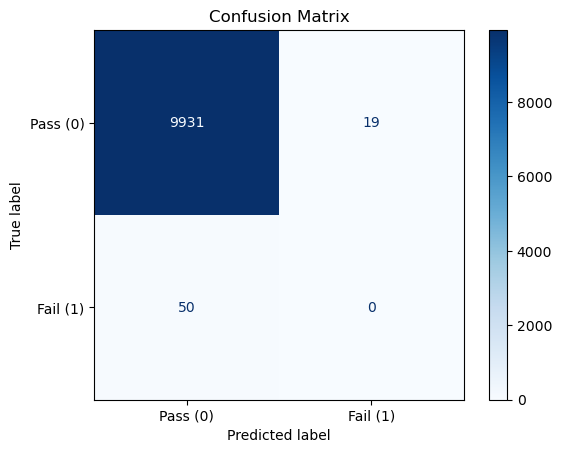

In [45]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ----------------------------
# Features & Target
# ----------------------------
X_train = train_data.drop(columns=['Response', 'synthetic_timestamp'])
y_train = train_data['Response']

X_test = test_data.drop(columns=['Response', 'synthetic_timestamp'])
y_test = test_data['Response']

# ----------------------------
# Handle Class Imbalance
# ----------------------------
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos if pos > 0 else 1
print(f"Class distribution → Negative: {neg}, Positive: {pos}, Scale weight: {scale_pos_weight:.2f}")

# ----------------------------
# Train XGBoost Model
# ----------------------------
model = xgb.XGBClassifier(
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    max_depth=5,
    learning_rate=0.1,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False
)

model.fit(X_train, y_train)

# ----------------------------
# Evaluate Model
# ----------------------------
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("\n📊 Evaluation Metrics")
print("Accuracy :", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall   :", round(rec, 4))
print("F1 Score :", round(f1, 4))

# ----------------------------
# Confusion Matrix
# ----------------------------
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pass (0)", "Fail (1)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Class distribution → Negative: 29831, Positive: 169, Scale weight: 176.51


C:\Users\Garima Joshi\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:42:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Evaluation Metrics (Threshold=0.1)
Accuracy : 0.9722
Precision: 0.0128
Recall   : 0.06
F1 Score : 0.0211


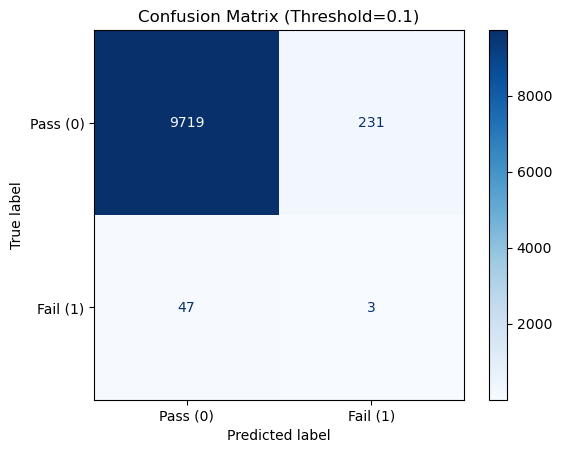

In [47]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ----------------------------
# Features & Target
# ----------------------------
X_train = train_data.drop(columns=['Response', 'synthetic_timestamp'])
y_train = train_data['Response']

X_test = test_data.drop(columns=['Response', 'synthetic_timestamp'])
y_test = test_data['Response']

# ----------------------------
# Handle Class Imbalance
# ----------------------------
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos if pos > 0 else 1
print(f"Class distribution → Negative: {neg}, Positive: {pos}, Scale weight: {scale_pos_weight:.2f}")

# ----------------------------
# Train XGBoost Model
# ----------------------------
model = xgb.XGBClassifier(
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    max_depth=5,
    learning_rate=0.1,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False
)

model.fit(X_train, y_train)

# ----------------------------
# Predict with custom threshold
# ----------------------------
y_proba = model.predict_proba(X_test)[:, 1]

# Lower threshold from 0.5 → 0.1
threshold = 0.1
y_pred = (y_proba > threshold).astype(int)

# ----------------------------
# Evaluate Model
# ----------------------------
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"\n📊 Evaluation Metrics (Threshold={threshold})")
print("Accuracy :", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall   :", round(rec, 4))
print("F1 Score :", round(f1, 4))

# ----------------------------
# Confusion Matrix
# ----------------------------
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pass (0)", "Fail (1)"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Threshold={threshold})")
plt.show()


Best Threshold = 0.0132
AUC = 0.5740

📊 Evaluation Metrics (Best Threshold)
Accuracy : 0.8119
Precision: 0.0096
Recall   : 0.36
F1 Score : 0.0188


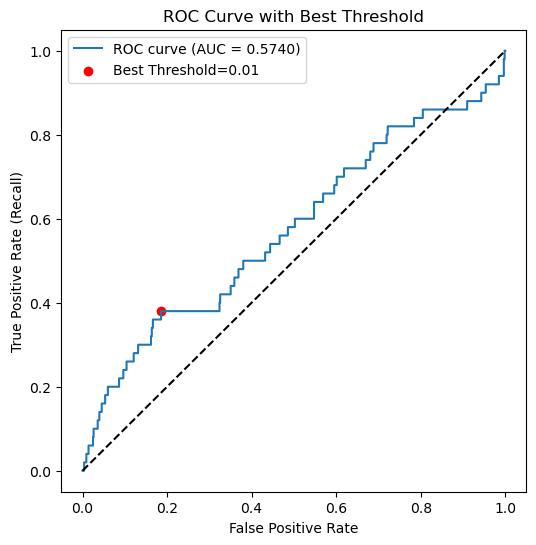

In [49]:
from sklearn.metrics import roc_curve, auc

# Get prediction probabilities
y_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Find best threshold (maximize tpr - fpr)
j_scores = tpr - fpr
j_best_idx = np.argmax(j_scores)
best_threshold = thresholds[j_best_idx]

print(f"Best Threshold = {best_threshold:.4f}")
print(f"AUC = {roc_auc:.4f}")

# Apply best threshold
y_pred = (y_proba > best_threshold).astype(int)

# Evaluate again
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("\n📊 Evaluation Metrics (Best Threshold)")
print("Accuracy :", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall   :", round(rec, 4))
print("F1 Score :", round(f1, 4))

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.scatter(fpr[j_best_idx], tpr[j_best_idx], color='red', label=f"Best Threshold={best_threshold:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve with Best Threshold")
plt.legend()
plt.show()
